In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [3]:
%pip install -Uqq pytorch-lightning==1.0.0 omegaconf

!pip uninstall torchtext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.4/510.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchtext-0.16.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchtext/*
Proceed (Y/n)? y
  Successfully uninstalled torchtext-0.16.0


In [4]:
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/drive/MyDrive/pytorch_retinanet")
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [6]:
#Set up paths

#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/drive/MyDrive/dataset"
VALID_IMAGE_PATH = False
TEST_IMAGE_PATH  = "/content/drive/MyDrive/dataset_test"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/content/drive/MyDrive/dataset"
VALID_ANNOT_PATH = False
TEST_ANNOT_PATH  = "/content/drive/MyDrive/dataset_test"

In [7]:
import torch
print(torch.cuda.is_available())

True


In [8]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np

from utils.pascal import convert_annotations_to_df

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

In [9]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = False
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")


def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = False
test_df  = remove_invalid_annots(test_df)

In [10]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/drive/MyDrive/dataset/foto05221.png,1280,720,drone,227,7,1072,376,1
1,/content/drive/MyDrive/dataset/foto05134.png,1280,720,drone,204,24,830,222,1
2,/content/drive/MyDrive/dataset/foto05163.png,1280,720,drone,132,61,1030,418,1
3,/content/drive/MyDrive/dataset/foto05192.png,1280,720,drone,220,51,1030,410,1
4,/content/drive/MyDrive/dataset/foto05105.png,1280,720,drone,327,41,959,271,1


In [11]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/drive/MyDrive/dataset_test/foto04815.png,1280,720,drone,568,218,771,347,1
1,/content/drive/MyDrive/dataset_test/foto04844.png,1280,720,drone,554,261,772,395,1
2,/content/drive/MyDrive/dataset_test/foto04873.png,1280,720,drone,544,276,786,439,1
3,/content/drive/MyDrive/dataset_test/foto04931.png,1280,720,drone,323,240,879,504,1
4,/content/drive/MyDrive/dataset_test/foto04902.png,1280,720,drone,447,283,721,448,1


In [12]:
#Paths where to save the generated dataframes
TRAIN_CSV =  "/content/drive/MyDrive/train_data.csv"
VALID_CSV = False
TEST_CSV  = "/content/drive/MyDrive/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=True)
#valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=True)

In [13]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = False
test_df  = pd.read_csv(TEST_CSV)

In [14]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 'drone']

In [15]:
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index

    Params
    ------
        dataframe : a pandas dataframe object
        index (int) : a integer corresponding to a index in the pandas dataframe

    Returns
    -------
        fname (str) : path to the selected image.
        bbbs (list) : a list containing the bounding box annotations for the `fname`.
        cls (list) : a list containing the integer class labels for the box annotations.
    """
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values
    return fname, bbs, cls

def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

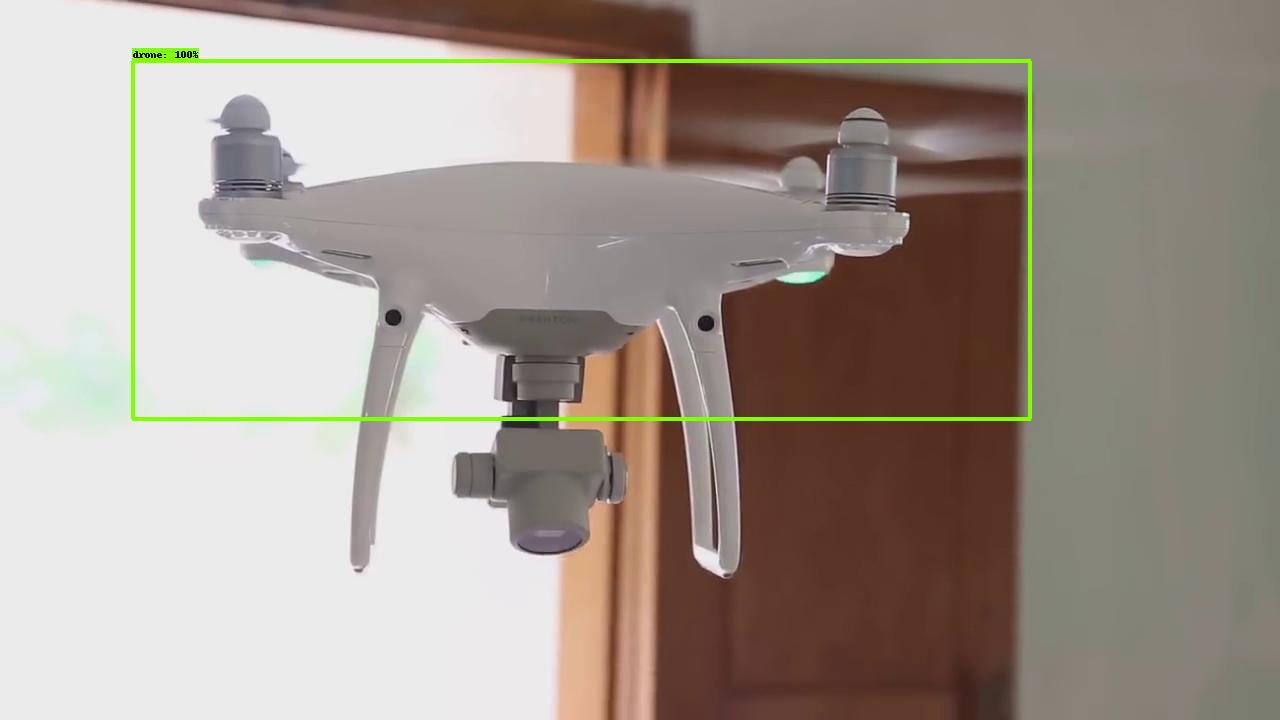

In [16]:
image = load_image_from_data(train_df, index=2)
image

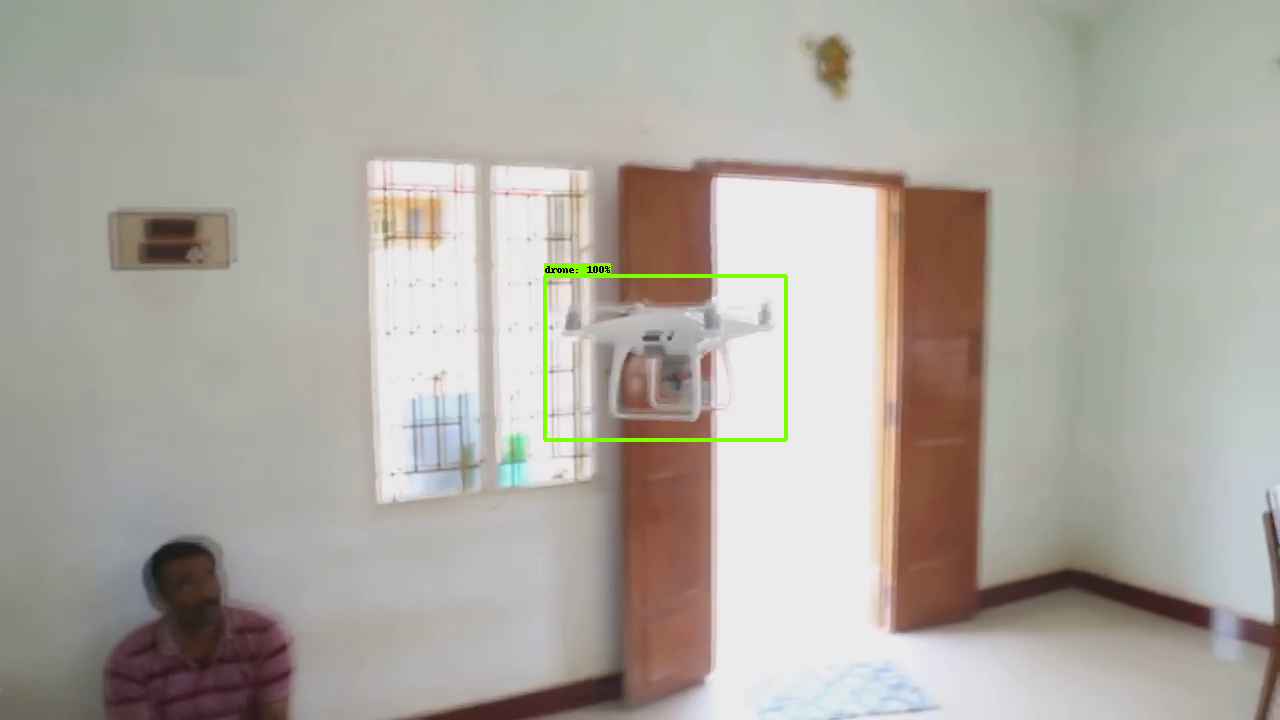

In [18]:
image = load_image_from_data(test_df, index=2)
image

In [19]:
NUM_TRAIN_EPOCHS = 50


from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/drive/MyDrive/pytorch_retinanet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV

hparams.dataloader.train_bs = 1
hparams.dataloader.valid_bs = 16
hparams.dataloader.test_bs  = 16

hparams.model.num_classes   = len(LABEL_MAP) - 1
hparams.model.backbone_kind = "resnet34"
hparams.model.min_size      = 800
hparams.model.max_size      = 1333
hparams.model.pretrained    = True #loads in imagenet-backbone weights

#transforms for the train_dataset
hparams.transforms  =  [
    {"class_name": "albumentations.HorizontalFlip", "params": {"p": 0.5} },
    {"class_name": "albumentations.ShiftScaleRotate", "params": {"p": 0.5} },
    {"class_name": "albumentations.RandomBrightnessContrast", "params": {"p": 0.5} },
]

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD",
    "params"    : {"lr": 0.001, "weight_decay": 0.0005, "momentum":0.9},
    }

#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.CosineAnnealingLR",
    "params"     : {"T_max": NUM_TRAIN_EPOCHS},
    "monitor"    : None,
    "interval"   : "epoch",
    "frequency"  : 1
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet34
  num_classes: 1
  freeze_bn: true
  min_size: 800
  max_size: 1333
  pretrained: true
dataset:
  kind: csv
  trn_paths: /content/drive/MyDrive/train_data.csv
  valid_paths: false
  test_paths: /content/drive/MyDrive/test_data.csv
dataloader:
  train_bs: 1
  valid_bs: 16
  test_bs: 16
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
- class_name: albumentations.ShiftScaleRotate
  params:
    p: 0.5
- class_name: albumentations.RandomBrightnessContrast
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.001
    weight_decay: 0.0005
    momentum: 0.9
scheduler:
  class_name: torch.optim.lr_scheduler.CosineAnnealingLR
  params:
    T_max: 50
  monitor: null
  interval: epoch
  frequency: 1



In [20]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

from model import RetinaNetModel

# seed so that results are reproducible
pl.seed_everything(123)

123

In [21]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE:
# For a list of whole trainer specific arguments see :
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

lr_logger  = LearningRateMonitor(logging_interval="step")

#instantiate LightningTrainer
trainer    = Trainer(precision=16, gpus=1, callbacks=[lr_logger], max_epochs=NUM_TRAIN_EPOCHS)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.


In [22]:
# Instantiate lightning-module
litModel = RetinaNetModel(conf=hparams)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 232MB/s]
BACKBONE     : resnet34
INFO:retinanet.models:BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 1
INFO:retinanet.models:NUM_CLASSES  : 1


In [23]:
trainer.fit(litModel)


  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  
INFO:retinanet.models:
  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

1

In [29]:
import torch
PATH = f"/content/drive/MyDrive/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

In [30]:
import logging
logger = logging.getLogger("lightning")

In [31]:
import retinanet
state_dict = torch.load(PATH)
from retinanet import Retinanet

#load saved model state dict
state_dict = torch.load(PATH)
#model arguments same as the arguments used to train the model
model_args = hparams.model
#load pytorch model without the lightning-module
#using args and state dict
MODEL      = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

BACKBONE     : resnet34
INFO:retinanet.models:BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 1
INFO:retinanet.models:NUM_CLASSES  : 1


In [32]:
!pip install ipywebrtc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 5.8 MB/s eta 0:00:00


In [33]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [35]:
from PIL import Image
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(image, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.

    Params
    ------
        image_path (str) : Path to the input Image
        threshold (float): Score threshold to filter predictions

    Returns
    -------
        A Dictionary contatining the predictions from generated from the model on
        the given image.
        Keys of the dictionary:
          - "boxes" : bounding-box co-ordinates
          - "labels": class labels for the bounding box co-ordinates.
          - "scores": scores for the bounding box co-ordinates.
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    INFER_TRANSFORMS = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True)
        ])

    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS  = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def detect(image, threshold=0.6):
    """
    Generate detections on the image that is present in
    the given image path

    Params
    ------
        image_path `(str)` : Path to the input Image
        threshold `(float)`: Score threshold to filter predictions

    Returns
    -------
        boxes  `(np.array)`: filtered absolute bounding box co-ordinates.
        labels `(np.array)`: class labels for the bounding box co-ordinates.
        scores `(np.array)`: scores for the bounding box co-ordinates.
    """
    # Generate predictions for the given image
    preds = get_preds(image, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask   = scores > threshold
    boxes  = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

def draw_on_image(image, boxes, scores, classes, label_map=LABEL_MAP):
    """
    Draw bounding box over the image at image path, with the scores and classes
    Returns a PIL image object.

    Params
    ------
        image_path `(str)`   : Path to the input Image
        boxes `(List[N,4])`  : absolute bouding box co-ordiates in the form `[xmin,ymin,xmax,ymax]`.
        scores `(List[N])`   : List containing the scores for each of the bounding box.
        classes `(`List[N])` : List containing the class_labels for each of the bounding box.
        label_map `(List)`   : List of the labels

    Returns
    -------
        A PIL Image object
    """
    image = image
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=scores, classes=classes, label_map=LABEL_MAP)
    return image



In [46]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
import io
import PIL.Image
from base64 import b64encode

def bbox_to_bytes(bbox_array):
    """
    Params:
        bbox_array: Numpy array (pixels) containing the rectangle to overlay on a video stream.
    Returns:
        bytes: Base64 image byte string
    """
    # Convert the array into a PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array)

    # Ensure that the array is in RGBA format
    if bbox_PIL.mode != 'RGBA':
        bbox_PIL = bbox_PIL.convert('RGBA')

    iobuf = io.BytesIO()
    # Format the bounding box into PNG for return
    bbox_PIL.save(iobuf, format='PNG')
    # Format the return string
    bbox_bytes = 'data:image/png;base64,{}'.format(b64encode(iobuf.getvalue()).decode('utf-8'))

    return bbox_bytes

In [47]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 1280; //video.videoWidth;
      captureCanvas.height = 720; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(labels, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (labels != "") {
        labelElement.innerHTML = labels;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(labels, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(labels, bbox))
  return data

In [ ]:
import cv2
import numpy as np
from PIL import Image
import io
from retinanet import Retinanet
import torch

# Start streaming video from the webcam
video_stream()
# Label for the video
label_html = ''
# Initialize bounding box to empty
bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Use your get_preds function for object detection
    boxes, labels, scores = detect(img, threshold=0.10)  # Pass 'img' directly

    # Draw bounding boxes on the image
    img_with_boxes = draw_on_image(np.array(img), boxes, scores, labels)

    # Convert the image with bounding boxes to an array
    bbox_array = np.array(img_with_boxes)

    # Convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Update bbox so the next frame gets a new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>